In [12]:
!pip install faker
!pip install geopy
!pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from faker import Faker
from geopy.distance import great_circle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

In [5]:
try:
    locations_df = pd.read_csv('locations.csv')
    print("Successfully loaded locations from CSV:")
    print(locations_df.head())
except FileNotFoundError:
    print("Error: 'locations.csv' not found. Please create it in the 'backend/data/' directory.")
    # Fallback to a minimal dictionary if file not found
    locations_df = pd.DataFrame([
        {'index': 0,'name': 'Bentonville', 'country': 'USA', 'latitude': 36.3729, 'longitude': -94.2088},
        {'index': 1,'name': 'Bangalore', 'country': 'India', 'latitude': 12.9716, 'longitude': 77.5946}
    ])



    
    
    

Successfully loaded locations from CSV:
   index           name country   latitude  longitude
0      0         Conway      US  35.108660 -92.436905
1      1       Sikeston      US  36.857394 -89.586051
2      2      Tahlequah      US  35.888765 -94.979859
3      3  Mountain Home      US  36.354957 -92.341026
4      4      Claremore      US  36.293955 -95.627125


In [14]:
fake = Faker()

def generate_dynamic_scan_data(n_records=10000, locations_df=locations_df):
    """Generates a DataFrame of simulated product scan data using a dynamic locations list."""
    data = []
    
    print(f"\nGenerating {n_records} normal scan records...")
    for _ in range(n_records):
        loc = locations_df.sample(1).iloc[0]
        data.append({
            'product_id': f'PID_{np.random.randint(1, 200)}',
            'user_id': f'UID_{np.random.randint(1, 1000)}',
            'timestamp': fake.date_time_between(start_date='-60d', end_date='now'),
            'latitude': loc['latitude'] + np.random.normal(0, 0.2), # Slightly larger radius
            'longitude': loc['longitude'] + np.random.normal(0, 0.2),
            'is_anomaly': 0
        })
        
    print("Generating dynamic anomalous scan records...")
    n_anomalies = int(n_records * 0.015)
    for i in range(n_anomalies):
        anomaly_type = np.random.choice(['velocity', 'geographic'])
        
        # --- THIS IS THE DYNAMIC FIX FOR VELOCITY ANOMALIES ---
        if anomaly_type == 'velocity':
            # Pick two random, distant cities from the dataset to create the anomaly
            while True:
                pair = locations_df.sample(2)
                loc1_details = pair.iloc[0]
                loc2_details = pair.iloc[1]
                
                # Calculate distance to ensure they are far apart for a good anomaly
                dist = great_circle((loc1_details['latitude'], loc1_details['longitude']), 
                                    (loc2_details['latitude'], loc2_details['longitude'])).kilometers
                
                if dist > 1000: # Ensure cities are at least 1000 km apart
                    break

            pid = f'PID_ANOM_FAST_{i}'
            ts = fake.date_time_between(start_date='-5d', end_date='now')
            data.append({'product_id': pid, 'user_id': 'UID_FRAUD_1', 'timestamp': ts, 'latitude': loc1_details['latitude'], 'longitude': loc1_details['longitude'], 'is_anomaly': 1})
            data.append({'product_id': pid, 'user_id': 'UID_FRAUD_2', 'timestamp': pd.to_datetime(ts) + pd.Timedelta(minutes=np.random.randint(5, 30)), 'latitude': loc2_details['latitude'], 'longitude': loc2_details['longitude'], 'is_anomaly': 1})
            
        # Geographic anomaly logic remains valid, as it's designed to be outside the dataset
        elif anomaly_type == 'geographic':
            data.append({
                'product_id': f'PID_ANOM_GEO_{i}', 'user_id': 'UID_FRAUD_3', 
                'timestamp': fake.date_time_between(start_date='-5d', end_date='now'), 
                'latitude': 51.5072, 'longitude': -0.1276, # London, UK (a clear geographic anomaly for a US dataset)
                'is_anomaly': 1
            })

    print("Data generation complete.")
    return pd.DataFrame(data)

# Generate the global data
df = generate_dynamic_scan_data(n_records=10000, locations_df=locations_df)

# Sort values and reset index
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nSample of generated global data:")
df.head()


Generating 10000 normal scan records...
Generating dynamic anomalous scan records...
Data generation complete.

Sample of generated global data:


,product_id,user_id,timestamp,latitude,longitude,is_anomaly
0,PID_21,UID_551,2025-04-17 19:12:46,32.799936,-95.818234,0
1,PID_40,UID_545,2025-04-17 19:13:23,27.361906,-81.689994,0
2,PID_196,UID_175,2025-04-17 19:20:38,36.613495,-80.706354,0
3,PID_49,UID_741,2025-04-17 19:23:56,32.850126,-95.902503,0
4,PID_190,UID_427,2025-04-17 19:29:57,43.139656,-108.546529,0


In [15]:
print("\nStarting feature engineering...")

# Sort data to ensure correct calculation of time/distance
df_sorted = df.sort_values(by=['product_id', 'timestamp']).reset_index(drop=True)

# Calculate time and distance between consecutive scans of the SAME product
df_sorted['time_diff_seconds'] = df_sorted.groupby('product_id')['timestamp'].diff().dt.total_seconds().fillna(0)

# A function to calculate distance
def calculate_distance(group):
    coords_1 = group[['latitude', 'longitude']]
    coords_2 = group[['latitude', 'longitude']].shift(1)
    distances = [great_circle(p1, p2).kilometers if pd.notna(p1[0]) and pd.notna(p2[0]) else 0 for p1, p2 in zip(coords_1.itertuples(index=False), coords_2.itertuples(index=False))]
    return pd.Series(distances, index=group.index)

df_sorted['distance_km'] = df_sorted.groupby('product_id').apply(calculate_distance).reset_index(level=0, drop=True).fillna(0)

# Calculate speed - our most powerful feature for velocity anomalies
# Add a small epsilon to avoid division by zero
df_sorted['speed_kmh'] = (df_sorted['distance_km'] / (df_sorted['time_diff_seconds'] / 3600.0)).fillna(0)

print("Feature engineering complete. New features: 'time_diff_seconds', 'distance_km', 'speed_kmh'")
print("\nSample of data with new features:")
df_sorted.tail()



Starting feature engineering...
Feature engineering complete. New features: 'time_diff_seconds', 'distance_km', 'speed_kmh'

Sample of data with new features:


C:\Users\USER\AppData\Local\Temp\ipykernel_14776\4228188851.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sorted['distance_km'] = df_sorted.groupby('product_id').apply(calculate_distance).reset_index(level=0, drop=True).fillna(0)


,product_id,user_id,timestamp,latitude,longitude,is_anomaly,time_diff_seconds,distance_km,speed_kmh
10223,PID_ANOM_GEO_86,UID_FRAUD_3,2025-06-13 02:17:44,51.5072,-0.1276,1,0.0,0.0,0.0
10224,PID_ANOM_GEO_88,UID_FRAUD_3,2025-06-16 08:38:30,51.5072,-0.1276,1,0.0,0.0,0.0
10225,PID_ANOM_GEO_95,UID_FRAUD_3,2025-06-14 23:38:28,51.5072,-0.1276,1,0.0,0.0,0.0
10226,PID_ANOM_GEO_96,UID_FRAUD_3,2025-06-13 13:46:11,51.5072,-0.1276,1,0.0,0.0,0.0
10227,PID_ANOM_GEO_99,UID_FRAUD_3,2025-06-15 17:05:34,51.5072,-0.1276,1,0.0,0.0,0.0



Starting EDA...


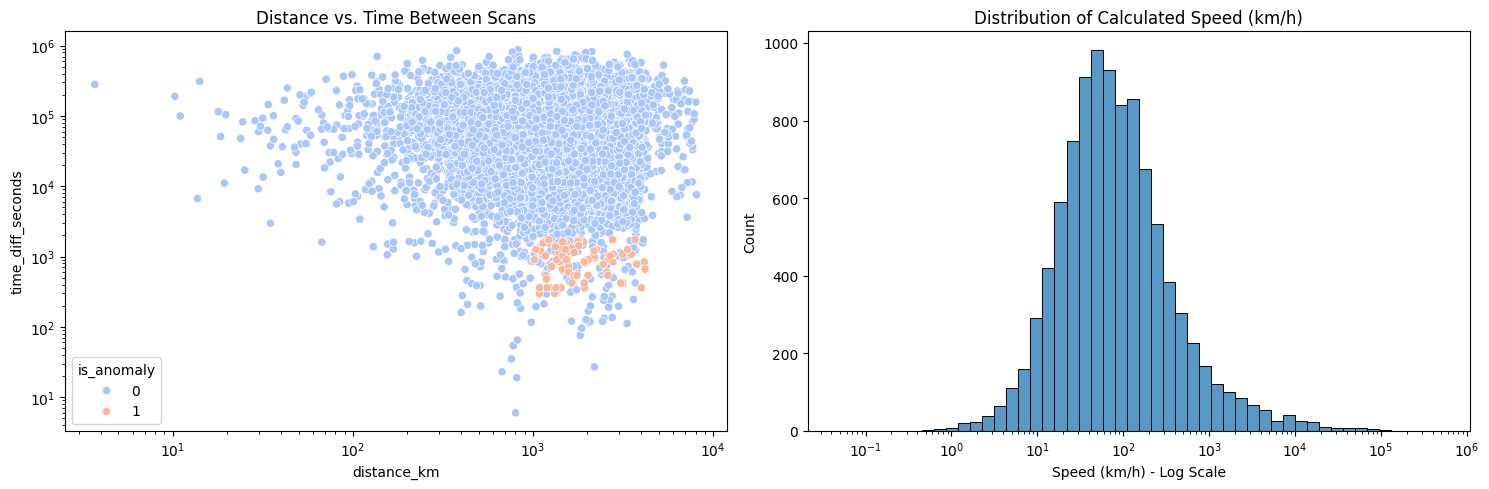

In [16]:
print("\nStarting EDA...")
#Distance vs. Time Between Scans and Distribution of Calculated Speed
plt.figure(figsize=(15, 5))

# Plot Speed
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_sorted, x='distance_km', y='time_diff_seconds', hue='is_anomaly', palette='coolwarm')
plt.title('Distance vs. Time Between Scans')
plt.xscale('log')
plt.yscale('log')

# Plot Speed Distribution
plt.subplot(1, 2, 2)
sns.histplot(df_sorted[df_sorted['speed_kmh'] > 0]['speed_kmh'], bins=50, log_scale=True)
plt.title('Distribution of Calculated Speed (km/h)')
plt.xlabel('Speed (km/h) - Log Scale')

plt.tight_layout()
plt.show()

'city' column already exists. Skipping mapping.


C:\Users\USER\AppData\Local\Temp\ipykernel_14776\2126939043.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_cities.index, x=top_20_cities.values, palette='viridis', orient='h')


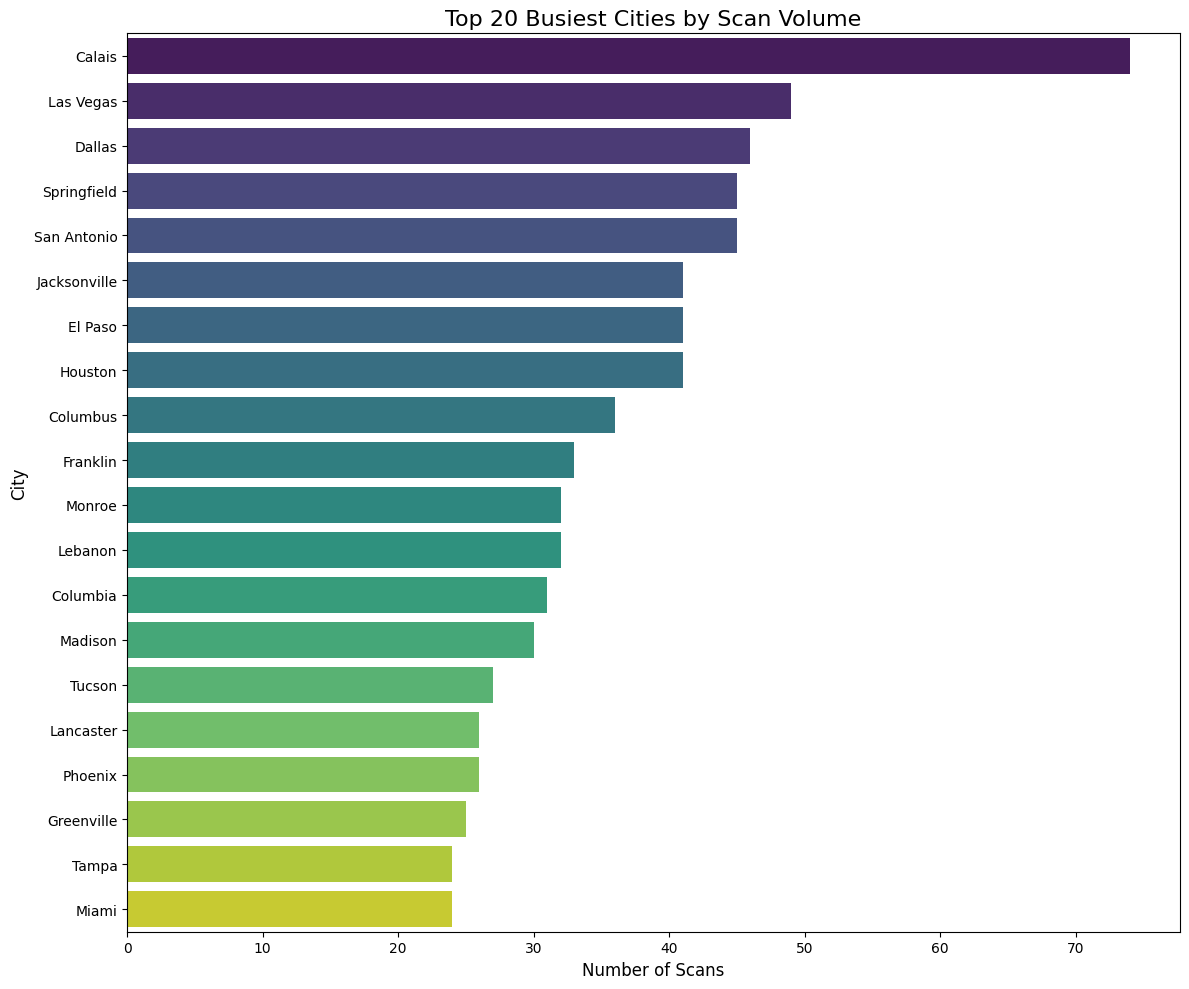

In [21]:
if 'city' not in df_sorted.columns:
    # Create a small DataFrame of just the unique city locations for easier mapping
    city_locations = locations_df[['latitude', 'longitude']].values
    city_names = locations_df['name'].values

    # A function to find the nearest city for each scan
    def find_nearest_city(lat, lon):
        scan_point = np.array([[lat, lon]])
        distances = cdist(scan_point, city_locations)
        nearest_index = np.argmin(distances)
        return city_names[nearest_index]

    print("Mapping scans to nearest city locations... (This may take a moment)")
    df_sorted['city'] = df_sorted.apply(lambda row: find_nearest_city(row['latitude'], row['longitude']), axis=1)
else:
    print("'city' column already exists. Skipping mapping.")


# --- THIS IS THE FIX ---
# 1. Calculate the value counts for all cities.
city_counts = df_sorted['city'].value_counts()

# 2. Select only the top 20 for plotting.
top_20_cities = city_counts.head(20)

# 3. Create a clean and readable plot.
plt.figure(figsize=(12, 10)) # Adjusted figure size for better readability
sns.barplot(y=top_20_cities.index, x=top_20_cities.values, palette='viridis', orient='h')
plt.title('Top 20 Busiest Cities by Scan Volume', fontsize=16)
plt.xlabel('Number of Scans', fontsize=12)
plt.ylabel('City', fontsize=12)
# Ensure labels on the y-axis are not cut off
plt.tight_layout()
plt.show()

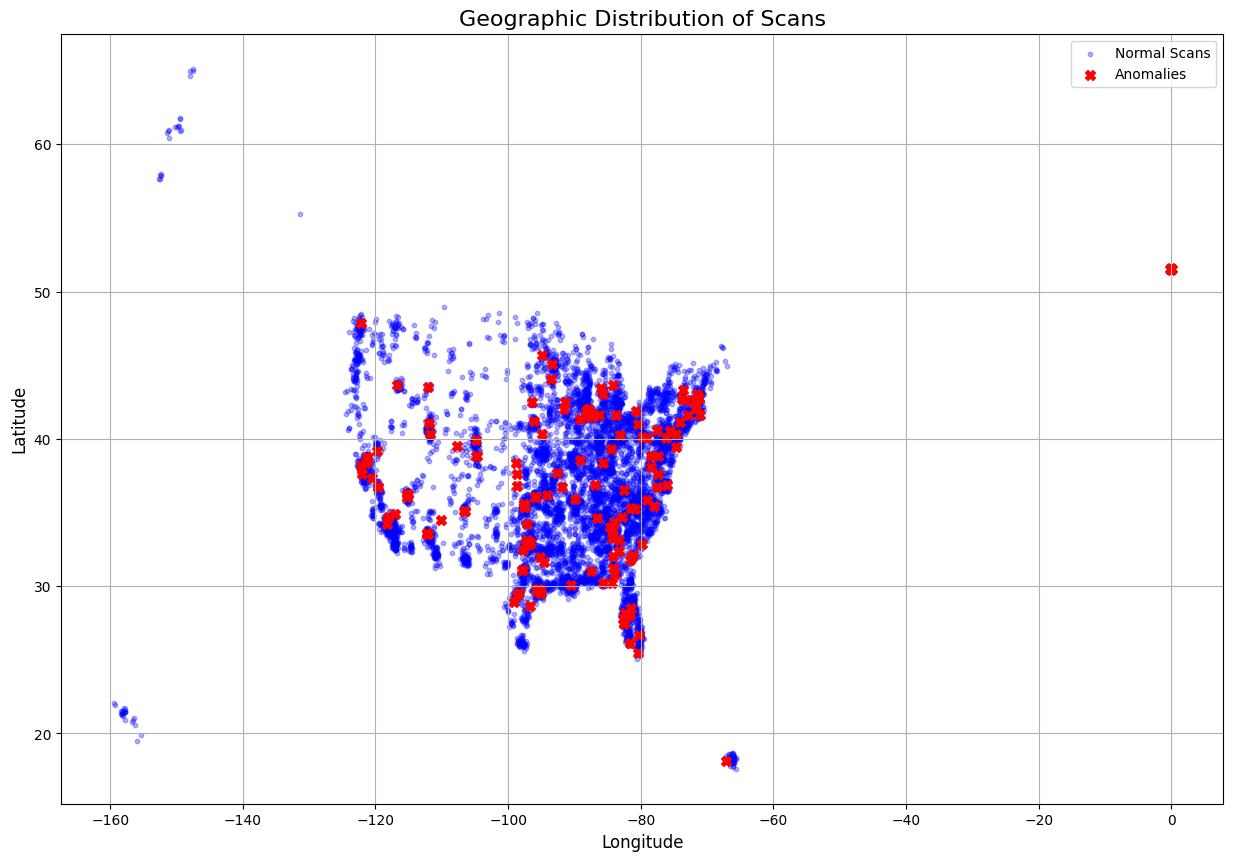

In [22]:
plt.figure(figsize=(15, 10))

# Plot normal data points
normal_data = df_sorted[df_sorted['is_anomaly'] == 0]
plt.scatter(normal_data['longitude'], normal_data['latitude'], alpha=0.3, s=10, label='Normal Scans', c='blue')

# Plot anomaly data points
anomaly_data = df_sorted[df_sorted['is_anomaly'] == 1]
plt.scatter(anomaly_data['longitude'], anomaly_data['latitude'], alpha=1.0, s=50, marker='X', label='Anomalies', c='red')

plt.title('Geographic Distribution of Scans', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14776\761975019.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_anomalous_products.index, y=top_10_anomalous_products.values, palette='Reds_r')


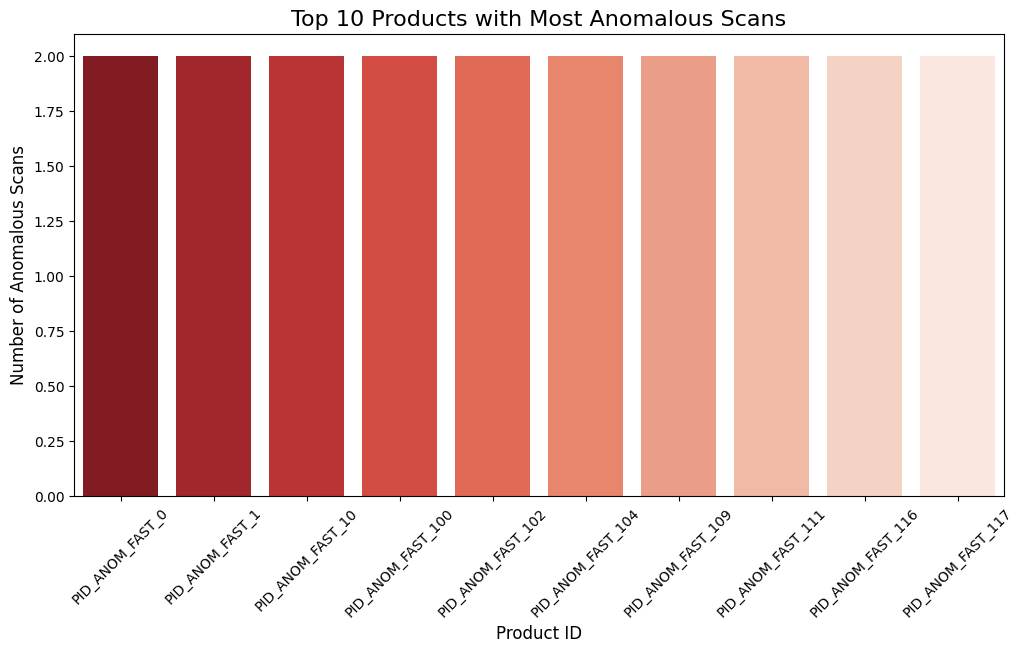

In [23]:
anomaly_counts_per_product = df_sorted[df_sorted['is_anomaly'] == 1]['product_id'].value_counts()

# Get the top 10 most anomalous products
top_10_anomalous_products = anomaly_counts_per_product.head(10)

if not top_10_anomalous_products.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=top_10_anomalous_products.index, y=top_10_anomalous_products.values, palette='Reds_r')
    plt.title('Top 10 Products with Most Anomalous Scans', fontsize=16)
    plt.xlabel('Product ID', fontsize=12)
    plt.ylabel('Number of Anomalous Scans', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No anomalous products found to plot.")

In [ ]:
print("\nTraining the Isolation Forest model...")

# Select features for the model
# We use the raw lat/lon as well as our engineered features
features = ['latitude', 'longitude', 'time_diff_seconds', 'distance_km', 'speed_kmh']
X = df_sorted[features]

# The 'contamination' parameter tells the model the expected proportion of anomalies.
# We set it slightly higher than our actual proportion to be safe.
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)

model.fit(X)

print("Model training complete.")


# In[6]:
# --- STEP 5: PREDICTION AND EVALUATION ---
# Let's use our trained model to predict which data points are anomalies.

# Predict: returns -1 for anomalies, 1 for inliers (normal points)
df_sorted['anomaly_prediction'] = model.predict(X)

# Let's see what the model flagged as an anomaly
anomalies_detected = df_sorted[df_sorted['anomaly_prediction'] == -1]

print(f"\nTotal records: {len(df_sorted)}")
print(f"Anomalies detected by model: {len(anomalies_detected)}")

print("\nDisplaying records flagged as anomalies by the AI model:")
# Show the most extreme examples
anomalies_detected.sort_values('speed_kmh', ascending=False).head(10)


# In[7]:
# --- STEP 6: VISUALIZING RESULTS ---

# Plotting the results to see if the model correctly separated the points.
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_sorted, x='distance_km', y='speed_kmh', hue='anomaly_prediction', palette={1: 'blue', -1: 'red'})
plt.title('AI Model Anomaly Detections')
plt.xlabel('Distance (km) - Log Scale')
plt.ylabel('Speed (km/h) - Log Scale')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Prediction', labels=['Anomaly', 'Normal'])
plt.show()


# In[8]:
# --- STEP 7: SAVING THE MODEL ---
# We save the trained model so our FastAPI backend can load and use it for live predictions.

model_filename = '../../backend/ml/models/isolation_forest_v1.joblib'
joblib.dump(model, model_filename)

print(f"\nModel successfully saved to: {model_filename}")